In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import *
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

# Parking Bay Usage by Area
Initially in this section, I am using the full Dataset from 2017 sensors. This gives information on time Occupied vs Time vacant in each parking bay. This is a high level look at overall usage of parking, and also split down to Area.

In [2]:
# Read in the 2017 full cleaned file. 
# Sorry in advance for the explicit variable naming

p_2017 = pd.read_csv('../Data/cleaned/parking_2017_cleaned.csv')

In [3]:
p_2017.head(3)

,arrival_time,departure_time,duration_seconds,street_marker,sign,area,street_name,side_of_street,in_violation,vehicle_present,sign_in_effect,duration_allowed,loading_zone,paid_park,disabled_park
0,2017-01-01 00:00:00,2017-01-01 00:56:53,3413,10001S,NaN,Southbank,SOUTHBANK BOULEVARD,4,False,True,False,NaN,False,False,False
1,2017-01-01 00:56:53,2017-01-01 02:11:39,4486,10001S,NaN,Southbank,SOUTHBANK BOULEVARD,4,False,False,False,NaN,False,False,False
2,2017-01-01 02:11:39,2017-01-01 02:13:30,111,10001S,NaN,Southbank,SOUTHBANK BOULEVARD,4,False,True,False,NaN,False,False,False


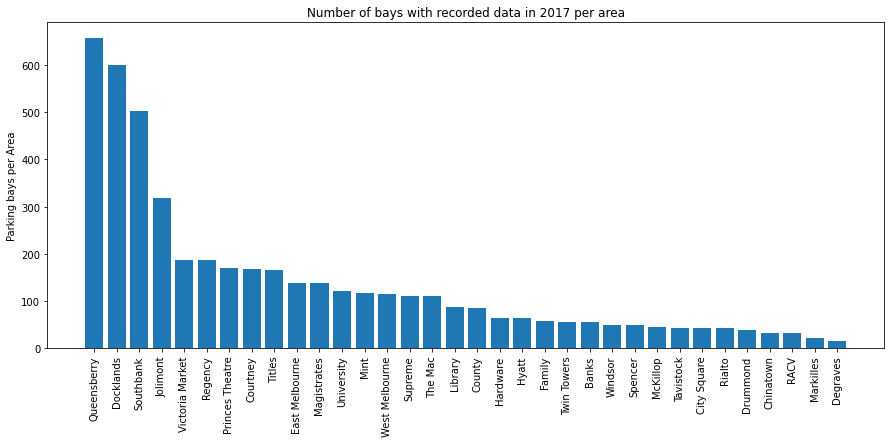

In [4]:
# Number of bays with recorded data in 2017 per area

bay_per_area = p_2017.groupby('area')['street_marker'].nunique()
bay_per_area = bay_per_area.sort_values(ascending=False)

plt.figure(figsize=(15,6))
plt.bar(x=bay_per_area.index, height=bay_per_area.values, data=bay_per_area)
plt.xticks(rotation = 90)
plt.ylabel('Parking bays per Area')
plt.title('Number of bays with recorded data in 2017 per area');

In [5]:
# Overall % utilisation of parking in 2017
# Taking the time recorded with vehicle present - time recorded with vehicle present..
# divided by total time
# Total time per bay is not a year worth of seconds due to faulty recorded data..
# or missing dates

vehicle_in_bay_time = p_2017[p_2017['vehicle_present']]['duration_seconds'].sum()
no_vehicle_in_bay_time = p_2017[p_2017['vehicle_present']==False]['duration_seconds'].sum()

total_util = round((vehicle_in_bay_time / (vehicle_in_bay_time + no_vehicle_in_bay_time))*100,2)

print(f'\nOn average {total_util}% of parking bays were in use at any given time in 2017\n')


On average 45.64% of parking bays were in use at any given time in 2017



In [6]:
# And when signs were in effect?

vehicle_in_bay_time_sign = p_2017[(p_2017['vehicle_present']) \
                           & (p_2017['sign_in_effect'])]['duration_seconds'].sum()
no_vehicle_in_bay_time_sign = p_2017[(p_2017['vehicle_present']==False) \
                              & (p_2017['sign_in_effect'])]['duration_seconds'].sum()

total_util_sign = round((vehicle_in_bay_time_sign\
                  / (vehicle_in_bay_time_sign + no_vehicle_in_bay_time_sign))*100,2)

print(f'\nOn average {total_util_sign}% of parking bays were in use when parking limits were active in 2017\n')


On average 53.32% of parking bays were in use when parking limits were active in 2017



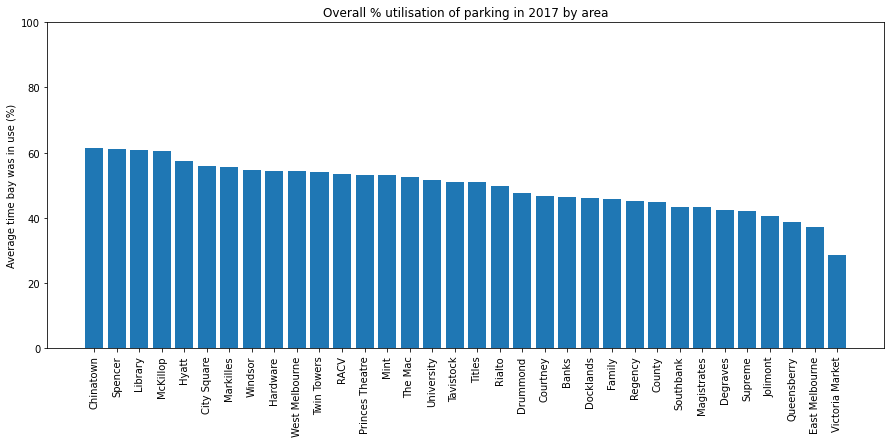

In [7]:
# Overall % utilisation of parking in 2017 by area

bay_in_use_area = p_2017[p_2017['vehicle_present']].\
                  groupby('area')['duration_seconds'].sum()
bay_not_in_use_area = p_2017[p_2017['vehicle_present']==False].\
                      groupby('area')['duration_seconds'].sum()

area_parking_util = round((bay_in_use_area \
                           / (bay_in_use_area + bay_not_in_use_area))*100,2)
area_parking_util = area_parking_util.sort_values(ascending=False)

plt.figure(figsize=(15,6))
plt.bar(x=area_parking_util.index, height=area_parking_util.values, data=area_parking_util)
plt.xticks(rotation = 90)
plt.ylabel('Average time bay was in use (%)')
plt.ylim(0, 100)
plt.title('Overall % utilisation of parking in 2017 by area');

The graph above shows the percentage overall use of parking bays in the different areas across Melbourne City. This includes night-time, so areas

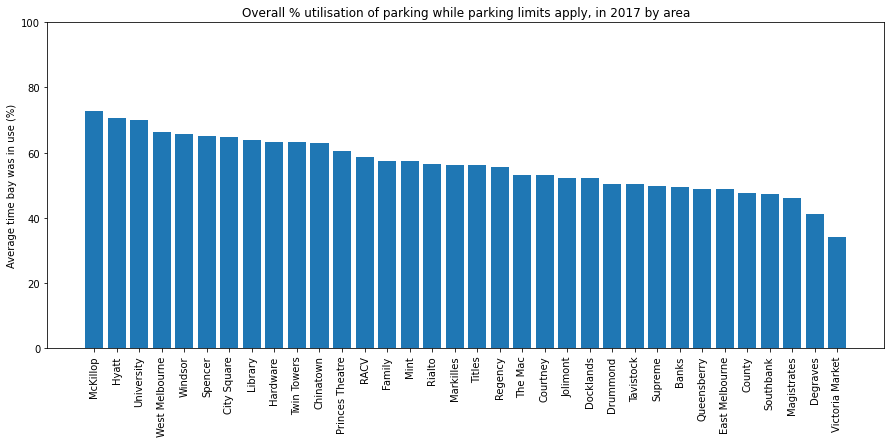

In [8]:
# Overall % utilisation of parking in 2017 by area, only during signed times

vehicle_in_bay_time_signed = p_2017[(p_2017['vehicle_present'])\
                            & (p_2017['sign_in_effect'])].\
                            groupby('area')['duration_seconds'].sum()
no_vehicle_in_bay_time_signed = p_2017[(p_2017['vehicle_present']==False)\
                            & (p_2017['sign_in_effect'])].\
                            groupby('area')['duration_seconds'].sum()

signed_parking_util = round((vehicle_in_bay_time_signed \
                    / (vehicle_in_bay_time_signed + no_vehicle_in_bay_time_signed))*100,2)
signed_parking_util = signed_parking_util.sort_values(ascending=False)

plt.figure(figsize=(15,6))
plt.bar(x=signed_parking_util.index, height=signed_parking_util.values, data=signed_parking_util)
plt.xticks(rotation = 90)
plt.ylabel('Average time bay was in use (%)')
plt.ylim(0, 100)
plt.title('Overall % utilisation of parking while parking limits apply, in 2017 by area');

# Drill Down to Bay Usage
This section explores a dataset that is roughly half the size of the previous one, where rows do not contain bay vacant records. This also allows filtering for when multiple records exist for one vehicle driving in and driving out. 

The analysis here is breaking down the usage of single bays, and providing an output to be processed for Tableau purposes.

 

In [9]:
# Read in the 2017 cars present only, full cleaned file. 

p_2017_vehicle_true = pd.read_csv('../Data/cleaned/parking_2017_cleaned_vehicle_present.csv')

In [10]:
# Number of parks in 2017 for sensored bays

total_parks = p_2017_vehicle_true[p_2017_vehicle_true['arrival_time']\
              != p_2017_vehicle_true['departure_time']\
              .shift(periods=1)]['arrival_time'].count()

total_parks = round(total_parks/1000000,1)

print(f'\nSensored parking bays in the City of Melbourne were used {total_parks} Mil times in 2017\n')


Sensored parking bays in the City of Melbourne were used 15.3 Mil times in 2017



In [11]:
# What about utilasation by single vehicles?
# Creating a new column to show the difference between time stayed and..
# time allowed to understand how long a person will remain in a spot for the given limit
# Helps to understand the average motorists behaviour
# This analysis ignores the time a vehicle can be in a bay before a sign comes into effect

p_2017_vehicle_true['duration_stay_perc'] = (p_2017_vehicle_true['duration_seconds']\
                                            / p_2017_vehicle_true['duration_allowed']).mul(100).round()

# Creating columns split for duration based on if a car is present or not

p_2017['use_time'] = p_2017[(p_2017['sign_in_effect'])\
                     & (p_2017['vehicle_present'])]['duration_seconds']
p_2017['empty_time'] = p_2017[(p_2017['sign_in_effect'])\
                       & (p_2017['vehicle_present']==False)]['duration_seconds']

In [12]:
# Let's get the average utilisation per bay during signed hours
# Average percentage of a vehicle's stay compared to possible stay
# Split up per bay, per duration allowed on signage
# Creating two DataFrames to merge in the end

bay_util = p_2017_vehicle_true[p_2017_vehicle_true['sign_in_effect']]\
           .groupby(['street_marker', 'duration_allowed'], as_index=False)['duration_stay_perc']\
           .agg(['mean', 'count']).round().reset_index()

bay_empty_time = p_2017[p_2017['sign_in_effect']]\
                 .groupby(['street_marker', 'duration_allowed']\
                 , as_index=False)[['use_time', 'empty_time']]\
                 .agg(['mean', 'count']).round().reset_index()

bay_util.rename(columns = {'mean':'avg_perc_stay',
                          'count':'cnt_use_rec'},
                          inplace=True)

bay_empty_time['avg_perc_empty'] = (bay_empty_time['empty_time']['mean']\
                                   / (bay_empty_time['empty_time']['mean']\
                                   + bay_empty_time['use_time']['mean'])).mul(100).round()

bay_empty_time['cnt_empty_rec'] = bay_empty_time['use_time']['count']

# Some outliers above 800% utilisation (40min in 5min bay), removing them
# Low instances also removed, assuming parking bays don't..
# get used less than 20 times during the year

bay_util = bay_util[(bay_util['avg_perc_stay']<800)]
bay_util = bay_util[(bay_util['cnt_use_rec']>20)]


In [13]:
# Had to do this because I created levels in the column index

bay_empty_time.columns = [''.join(col) for col in bay_empty_time.columns]
bay_empty_time
bay_empty_time.drop(columns=['use_timemean','use_timecount','empty_timemean','empty_timecount'], inplace=True)
bay_empty_time = bay_empty_time[(bay_empty_time['cnt_empty_rec']>20)]

In [14]:
# Duration stay column needs to be changed to mins and as int

bay_util['duration_allowed'] = bay_util['duration_allowed'].div(60).astype('int')
bay_empty_time['duration_allowed'] = bay_empty_time['duration_allowed'].div(60).astype('int')

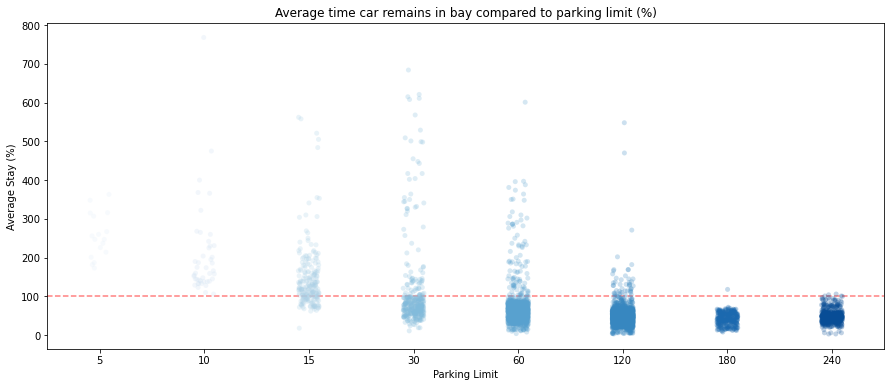

In [45]:
# Plotting the spread of duration allowed vs percentage stay
# Above %100 means the average user overstays the limit of the bay

plt.figure(figsize=(15,6))
sns.stripplot(x='duration_allowed', y='avg_perc_stay',
              data=bay_util, alpha=.25, palette='Blues')
plt.title('Average time car remains in bay compared to parking limit (%)')
plt.axhline(y=100, color='r', linestyle='--', alpha=0.5)
plt.ylabel('Average Stay (%)')
plt.xlabel('Parking Limit');

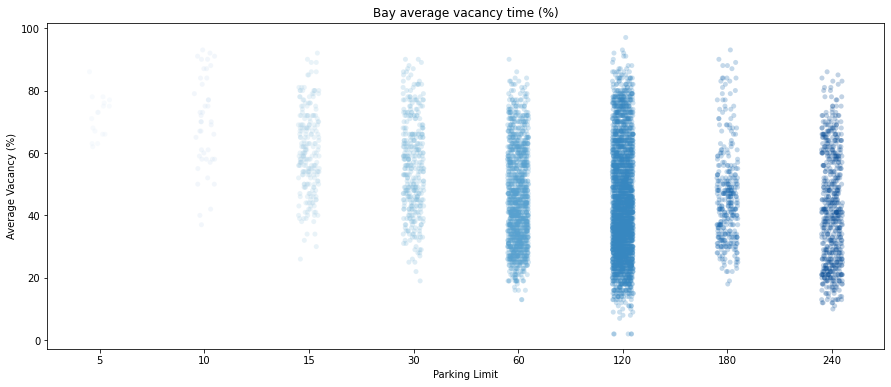

In [46]:
# Plotting the spread of duration allowed vs avg empty time between cars

plt.figure(figsize=(15,6))
sns.stripplot(x='duration_allowed', y='avg_perc_empty',
              data=bay_empty_time, alpha=.25, palette='Blues')
plt.title('Bay average vacancy time (%)')
plt.ylabel('Average Vacancy (%)')
plt.xlabel('Parking Limit');

#### Creating output for Tableau

In [17]:
# Using max to capture if a spot is EVER a loading zone, paid park or disabled park

p_2017_bays = p_2017_vehicle_true.groupby(['street_marker', 'duration_allowed'])\
              .max().reset_index()
p_2017_bays.drop(columns=['arrival_time','departure_time','duration_seconds',\
                             'sign', 'in_violation', 'vehicle_present',\
                             'sign_in_effect', 'duration_stay_perc'],\
                              inplace=True)

In [18]:
p_2017_bays = p_2017_bays.merge(bay_empty_time, \
                                on='street_marker', how='left')\
                                .merge(bay_util, \
                                on='street_marker', how='left')

p_2017_bays.to_csv('../Data/cleaned/bays_2017.csv',encoding='utf-8')

#### Plot of Vacant Time (%) to Occupied Time as a Percentage of the Timelimit

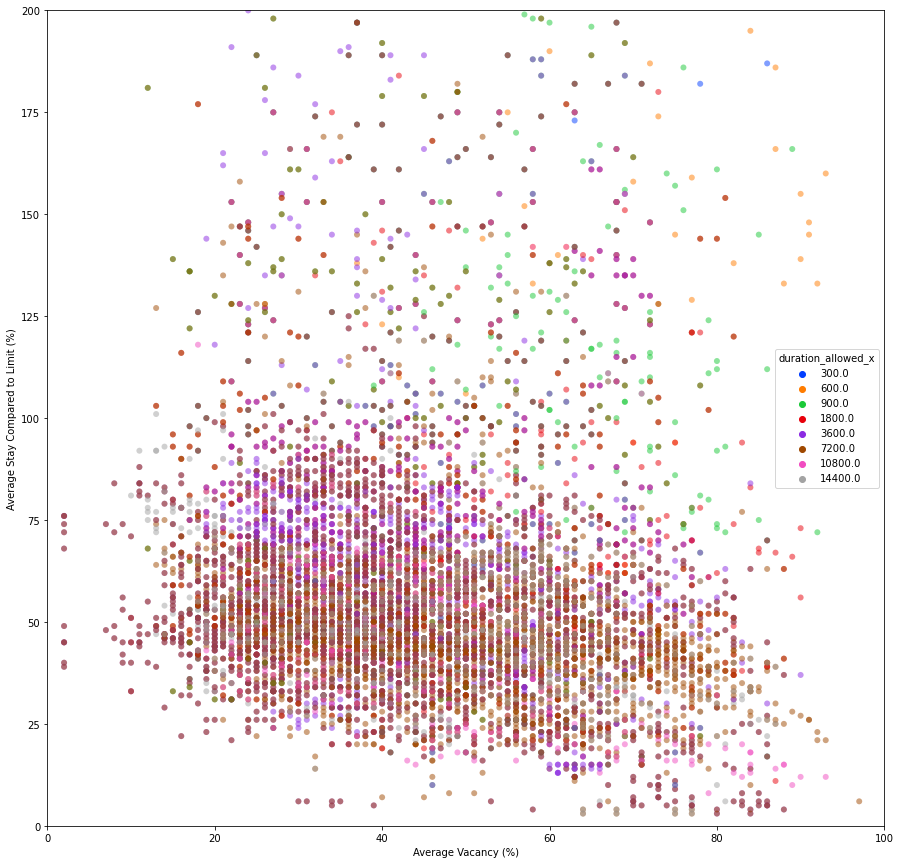

In [47]:
# To be used in Tableau dashboard for better vis

plt.figure(figsize=(15,15))
sns.scatterplot(x='avg_perc_empty', y='avg_perc_stay',data=p_2017_bays,
                hue='duration_allowed_x', \
                alpha=0.5, palette='bright', linewidth=0)
plt.xlim(0, 100)
plt.ylim(0, 200)
plt.ylabel('Average Stay Compared to Limit (%)')
plt.xlabel('Average Vacancy (%)');

# Parking as a Function of Time 

Using the dataset with cars present only again, to look at parking bay usage in different time periods. This is all to get an understanding of overall parking behaviour over time perdiods, so that usage can be predicted for the future. 

Part of next steps would be to get data into parking bay removal (removal of supply) and see how that affects demand over time. Ideally the demand would also drop, as people travelling to the city (are required to) change their mode of transport.

In [22]:
# Put Python to work and convert Time columns to datetime dtype. Long runtime, avoid use
# Remove as many records as possible first, before running this

p_2017_vehicle_true['arrival_time'] = \
    pd.to_datetime(p_2017_vehicle_true['arrival_time'], infer_datetime_format=True)

p_2017_vehicle_true['departure_time'] = \
    pd.to_datetime(p_2017_vehicle_true['departure_time'], infer_datetime_format=True)

In [23]:
p_2017_vehicle_true.dtypes

arrival_time          datetime64[ns]
departure_time        datetime64[ns]
duration_seconds               int64
street_marker                 object
sign                          object
area                          object
street_name                   object
side_of_street                 int64
in_violation                    bool
vehicle_present                 bool
sign_in_effect                  bool
duration_allowed             float64
loading_zone                    bool
paid_park                       bool
disabled_park                   bool
duration_stay_perc           float64
dtype: object

In [24]:
# Calculating the vehicles arriving per hour during day on average
# Shift function used to filter parking events overlapping when a sign comes into effect..
# or the date changes while a car is still parked..
# changing it to only one arrival per car by removing the extra events above

car_hour_arrived = p_2017_vehicle_true[p_2017_vehicle_true['arrival_time']\
                   != p_2017_vehicle_true['departure_time']\
                   .shift(periods=1)]\
                   ['duration_seconds'].groupby(p_2017_vehicle_true['arrival_time']\
                   .dt.hour).count().div(365)

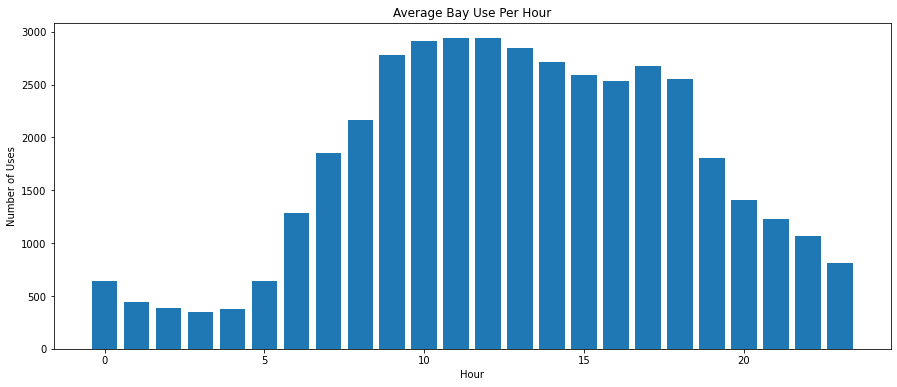

In [25]:
plt.figure(figsize=(15,6))
plt.bar(car_hour_arrived.index, car_hour_arrived.values)
plt.title('Average Bay Use Per Hour')
plt.ylabel('Number of Uses')
plt.xlabel('Hour');

In [26]:
# Same as above, but now with weekday

car_wkday_arrived = p_2017_vehicle_true[p_2017_vehicle_true['arrival_time']\
                    != p_2017_vehicle_true['departure_time']\
                    .shift(periods=1)]\
                    ['duration_seconds'].groupby(p_2017_vehicle_true['arrival_time']\
                    .dt.dayofweek).count().div(52)

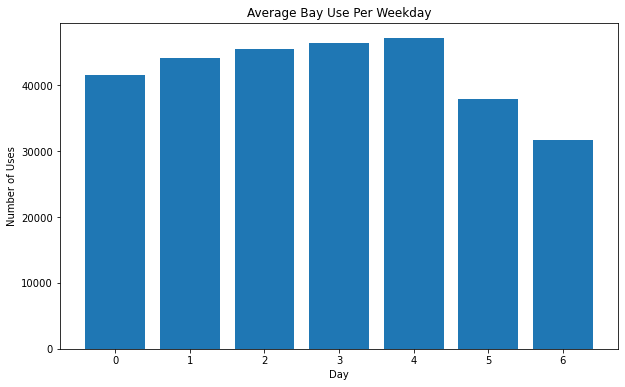

In [27]:
plt.figure(figsize=(10,6))
plt.bar(car_wkday_arrived.index, car_wkday_arrived.values)
plt.title('Average Bay Use Per Weekday')
plt.ylabel('Number of Uses')
plt.xlabel('Day');

In [28]:
# And again, but now with date

car_date_arrived = p_2017_vehicle_true[p_2017_vehicle_true['arrival_time']\
                   != p_2017_vehicle_true['departure_time']\
                   .shift(periods=1)]\
                   ['duration_seconds'].groupby(p_2017_vehicle_true['arrival_time'].dt.date).count()

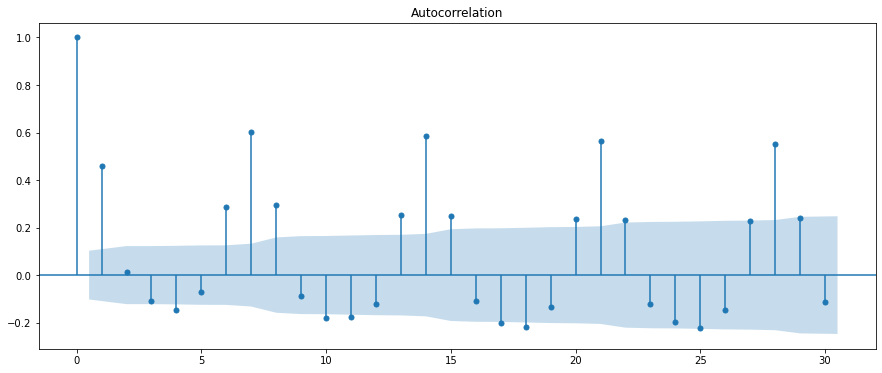

In [29]:
# Running autocorrelation to confirm that the normal pattern is a weekly cycle
# Correlates a value vs its own value at period difference (day in this case) 
# So 7 days difference has significant correlation, cycle is weekly
 
plt.rc('figure', figsize=(15,6))
plot_acf(car_date_arrived.values, lags=30)
plt.show()

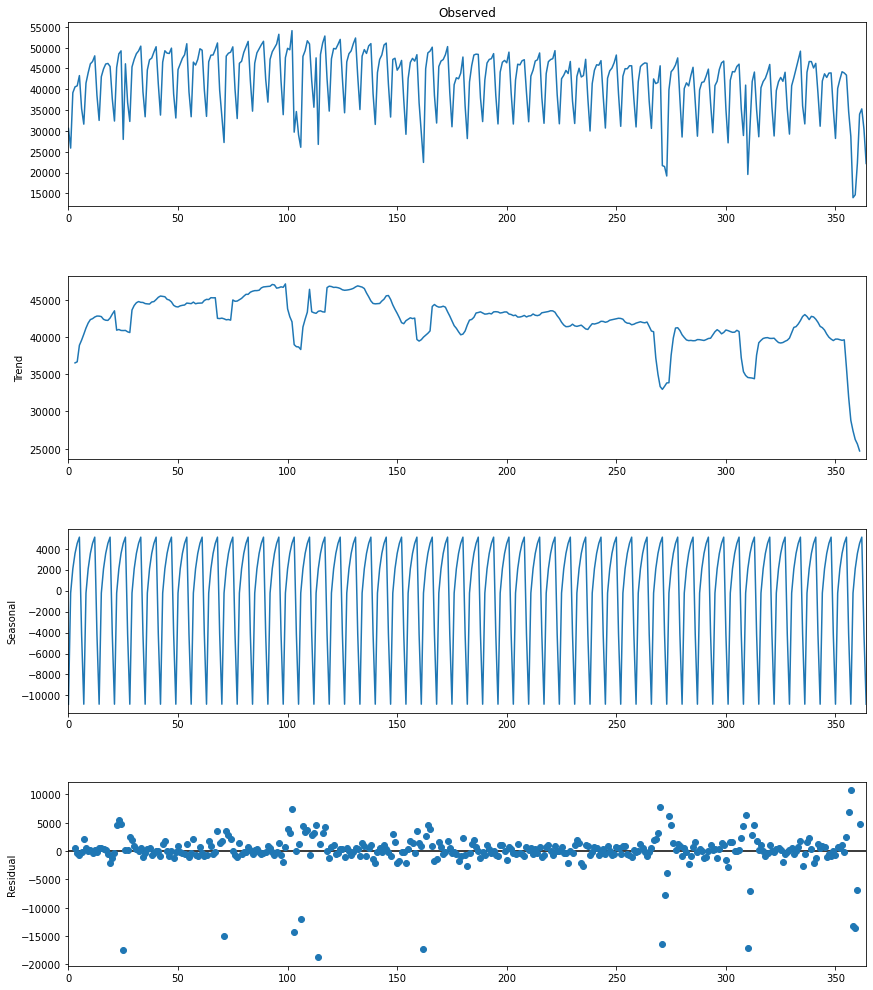

In [30]:
# A downward trend?!
# Does this mean that parking bays are being used less as the year goes on, 
# or that parking bays are being removed?
# Trend has some dips that look to be caused by public holidays
# Residual also shows large drops from the norm around public holidays
# Seasonal is the average pattern over a 7 day period
# Residual is how far the actual value differs from the trend combined with seasonal

decomposition = seasonal_decompose(car_date_arrived.values, period=7)  
fig = decomposition.plot()  
fig.set_size_inches(12, 15);

In [31]:
st_mkr_by_date = p_2017_vehicle_true.groupby(p_2017_vehicle_true['arrival_time']\
                                             .dt.isocalendar().week)['street_marker'].nunique()

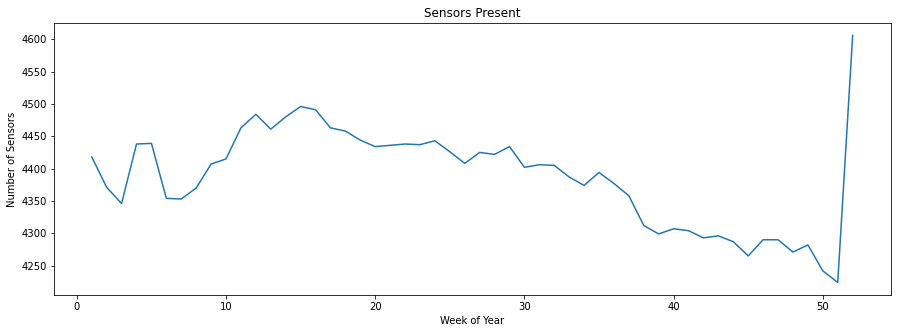

In [43]:
# In the two plots below, we can see the trend follows the drop in bays(sensors)
# Need to investigate further, as overall there may be no trend in parking over a year

plt.figure(figsize=(15,5))
plt.plot(st_mkr_by_date.index, st_mkr_by_date.values)
plt.title('Sensors Present')
plt.ylabel('Number of Sensors')
plt.xlabel('Week of Year');

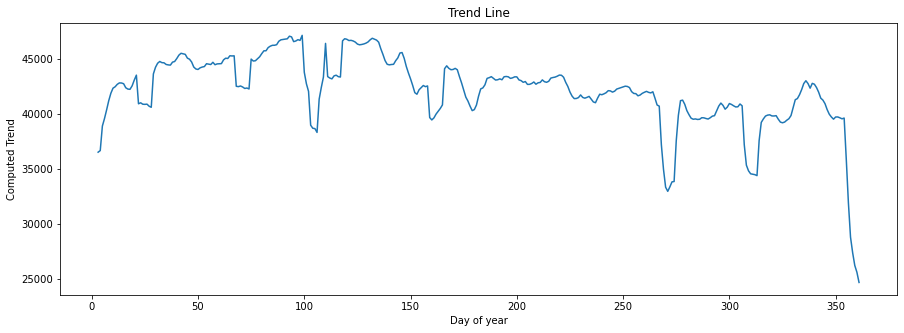

In [44]:
trend = decomposition.trend
plt.figure(figsize=(15,5))
plt.plot(trend)
plt.title('Trend Line')
plt.ylabel('Computed Trend')
plt.xlabel('Day of year');

# Parking Violations
This is taking a look into the dataset of parking violations, where the duration of stay exceeds the parking limit on the sign. This again is a high level look at areas in Melbourne to get an idea of overall behaviour. 

Different areas have different usage requirements. For instance, the closer you get to the center of the city, the shorter the parking limits are in general. So the final chart looks at the likely amount of time a user will stay passed the limit, based on signage.

In [34]:
# Read in the 2017 violations, full cleaned file. 

p_2017_violations = pd.read_csv('../Data/cleaned/parking_2017_cleaned_violation.csv')

In [35]:
# Calculating total violations

violation_count = p_2017_violations['arrival_time'].count()
violation_count = round(violation_count/1000000,1)

print(f'\nThe total number of instances with vehicles overstaying their limit in 2017 was {violation_count} Mil\n')


The total number of instances with vehicles overstaying their limit in 2017 was 1.5 Mil



In [36]:
viol_by_area = p_2017_violations.groupby('area')['street_marker'].agg(['count','nunique'])

viol_by_area = viol_by_area.sort_values('count', ascending=False)

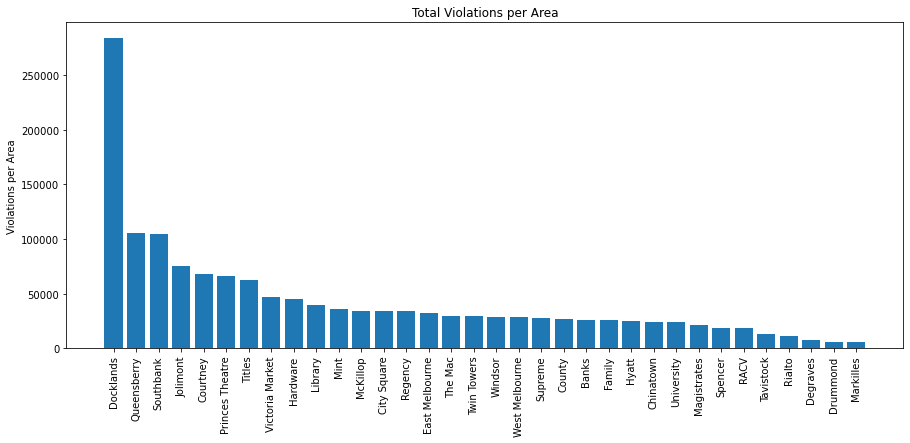

In [37]:
# Docklands clearly has the most violations, but it also has a lot of bays
# Need to look into violations per bay

plt.figure(figsize=(15,6))
plt.bar(x=viol_by_area.index, height=viol_by_area['count'], data=viol_by_area)
plt.xticks(rotation = 90)
plt.ylabel('Violations per Area')
plt.title('Total Violations per Area');

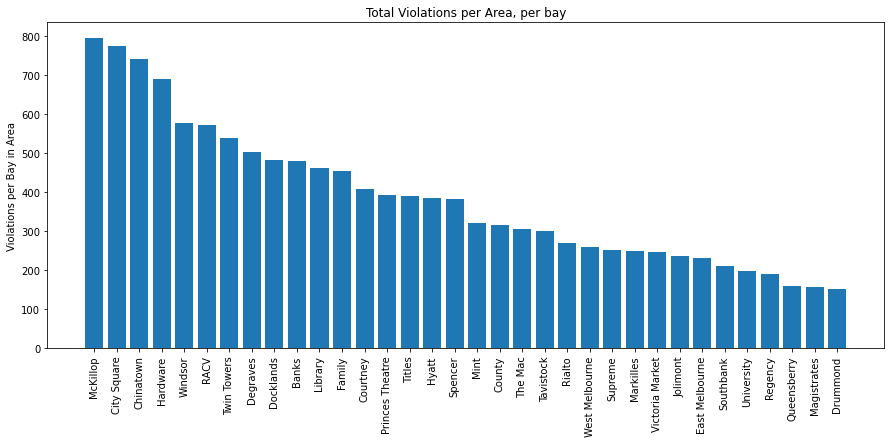

In [38]:
viol_by_area['viol_per_bay'] =  viol_by_area['count'] / viol_by_area['nunique']

viol_by_area = viol_by_area.sort_values('viol_per_bay', ascending=False)

plt.figure(figsize=(15,6))
plt.bar(x=viol_by_area.index, height=viol_by_area['viol_per_bay'], data=viol_by_area)
plt.xticks(rotation = 90)
plt.ylabel('Violations per Bay in Area')
plt.title('Total Violations per Area, per bay');

In [39]:
p_2017_violations['overstay'] = p_2017_violations['duration_seconds'] - p_2017_violations['duration_allowed']

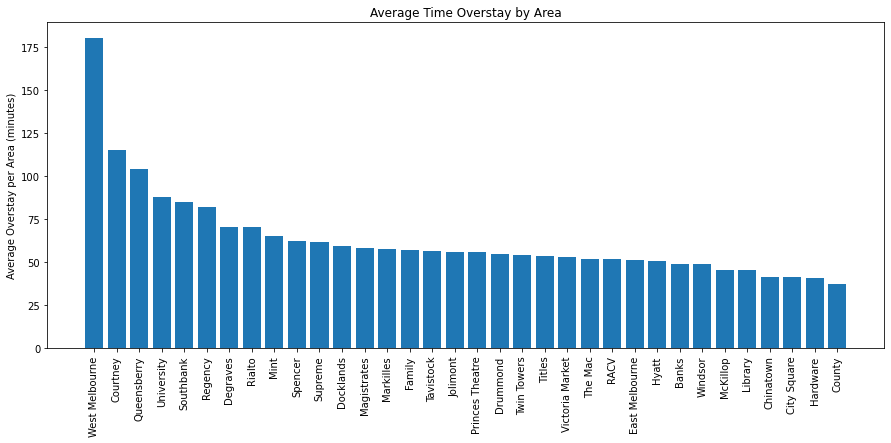

In [40]:
overstay_area = p_2017_violations.groupby('area')['overstay']\
                .agg('mean').div(60).round(2)

overstay_area = overstay_area.sort_values(ascending=False)

plt.figure(figsize=(15,6))
plt.bar(x=overstay_area.index, height=overstay_area.values, data=overstay_area)
plt.xticks(rotation = 90)
plt.ylabel('Average Overstay per Area (minutes)')
plt.title('Average Time Overstay by Area');

In [41]:
plot_dur = p_2017_violations.groupby('duration_allowed')['overstay']\
           .agg(['max','mean', 'min']).div(60).round(2).reset_index()

plot_dur['duration_allowed'] = plot_dur['duration_allowed'].div(60).astype('int')

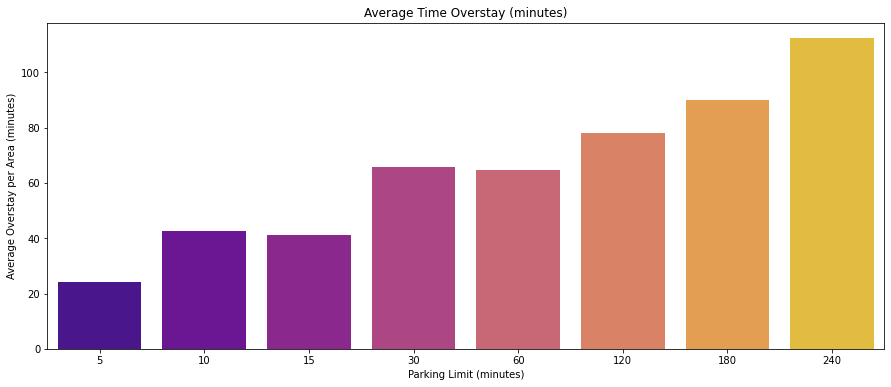

In [42]:
sns.barplot(data=plot_dur, x=plot_dur['duration_allowed'], y='mean', palette="plasma")
plt.ylabel('Average Overstay (minutes)')
plt.xlabel('Parking Limit (minutes)')
plt.title('Average Time Overstay (minutes)');